# Ensemble Kalman Filter with Lorenz 96 System

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))

from src.lorenz_systems.lorenz96 import solve_lorenz96
from src.lorenz_systems.enkf import EnsembleKalmanFilter

In [2]:
# System parameters
N_vars = 40  # Number of variables in the Lorenz 96 system
F = 8.0  # Forcing

# Generate true trajectory
x0_true = F * np.ones(N_vars)
x0_true[N_vars // 2] += 0.01  # Perturbation
t_span = [0, 5]
t_eval = np.linspace(t_span[0], t_span[1], 250)
true_sol = solve_lorenz96(x0_true, t_span, t_eval, F)

# Create noisy observations
R_true = np.eye(N_vars) * 0.5  # Observation noise covariance
y = true_sol.y + np.random.multivariate_normal(np.zeros(N_vars), R_true, len(t_eval)).T

In [3]:
# Initialize EnKF
N_ens = 100  # Number of ensemble members
enkf = EnsembleKalmanFilter(model=solve_lorenz96, R=R_true, N=N_ens)

# Initial ensemble
X0 = np.random.multivariate_normal(x0_true, np.eye(N_vars) * 1.0, N_ens).T

In [4]:
# Run the EnKF
X_hist = [X0]
x_mean_hist = [np.mean(X0, axis=1)]

for i in range(1, len(t_eval)):
    t_step_span = [t_eval[i-1], t_eval[i]]
    t_step_eval = np.array([t_eval[i]])
    
    # Forecast
    X_f = enkf.forecast(X_hist[-1], t_step_span, t_step_eval, F)
    
    # Analysis
    X_a = enkf.analysis(X_f, y[:, i], H=np.eye(N_vars))
    
    X_hist.append(X_a)
    x_mean_hist.append(np.mean(X_a, axis=1))

x_mean_hist = np.array(x_mean_hist)

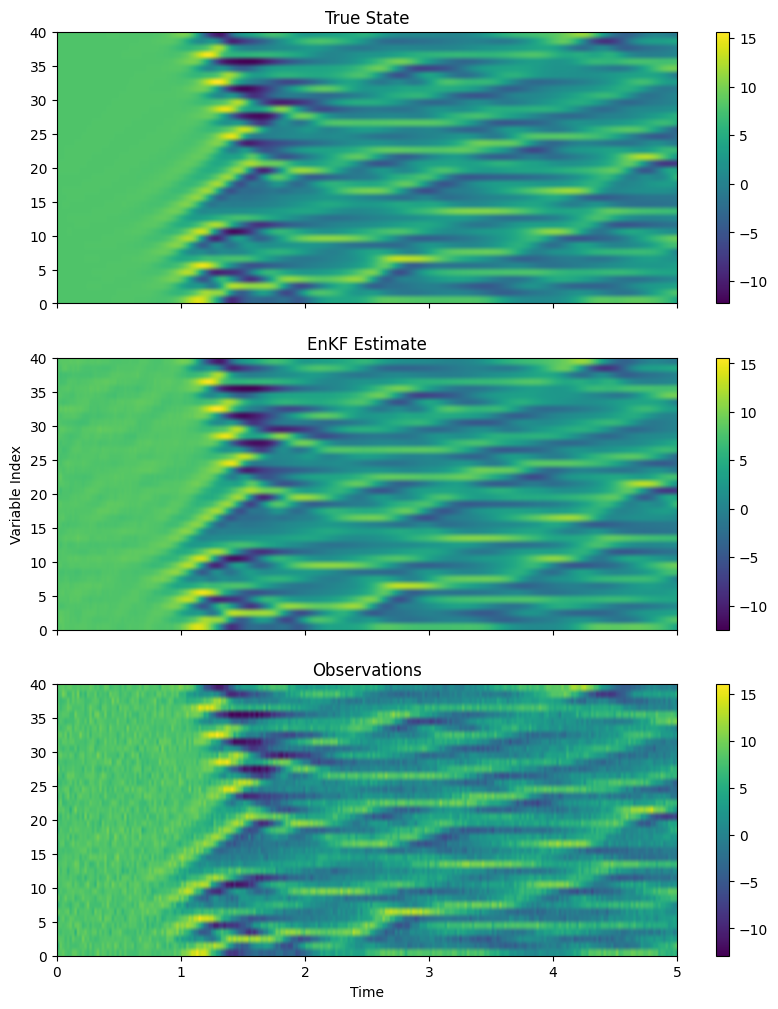

In [5]:
# Plot the results
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True, sharey=True)

# Plot true state
im0 = axes[0].imshow(true_sol.y, aspect='auto', extent=[t_span[0], t_span[1], 0, N_vars])
axes[0].set_title('True State')
fig.colorbar(im0, ax=axes[0])

# Plot EnKF mean estimate
im1 = axes[1].imshow(x_mean_hist.T, aspect='auto', extent=[t_span[0], t_span[1], 0, N_vars])
axes[1].set_title('EnKF Estimate')
axes[1].set_ylabel('Variable Index')
fig.colorbar(im1, ax=axes[1])

# Plot observations
im2 = axes[2].imshow(y, aspect='auto', extent=[t_span[0], t_span[1], 0, N_vars])
axes[2].set_title('Observations')
axes[2].set_xlabel('Time')
fig.colorbar(im2, ax=axes[2])

plt.show()